In [168]:
# Author: Yilin ZHENG
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from hmmlearn.hmm import GaussianHMM
np.random.seed(23)

In [169]:
file = "./1990-201310日线.csv"
data = pd.read_csv(file)
display(data.head(n=5))

,Symbol,Name,Date,Open,Low,High,Close,Volume,Amount
0,SH000001,上证指数,1990-12-19 00:00:00,96.05,95.79,99.98,99.98,1260,494000.0
1,SH000001,上证指数,1990-12-20 00:00:00,104.30,99.98,104.39,104.39,197,84000.0
2,SH000001,上证指数,1990-12-21 00:00:00,109.07,103.73,109.13,109.13,28,16000.0
3,SH000001,上证指数,1990-12-24 00:00:00,113.57,109.13,114.55,114.55,32,31000.0
4,SH000001,上证指数,1990-12-25 00:00:00,120.09,114.55,120.25,120.25,15,6000.0


In [200]:
def get_price(file_name, name, start_date, end_date):
    data = pd.read_csv(file_name)
    data["Date"] = data["Date"].astype("<M8[ns]")
    data = data[data["Symbol"] == name]
    tmp = data[data.Date > start_date]
    data2 = tmp[tmp.Date < end_date]
    return data2

In [201]:
def get_features(file_name, name, start_date, end_date):
    data = get_price(file_name, name, start_date, end_date)
    volume = data["Volume"]
    close = data["Close"]
    log_del = np.log(np.array(data["High"])) - np.log(np.array(data["Low"]))
    log_ret_1 = np.array(np.diff(np.log(close)))
    log_ret_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
    log_vol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))
    log_del = log_del[5:]
    log_ret_1 = log_ret_1[4:]
    close = close[5:]
    Date = data.Date[5:]
    A = np.column_stack([log_del, log_ret_5, log_vol_5])
    return A, Date, close, log_ret_1   

In [211]:
# parameters
n = 4
name = "SH000001"
begin = "2005-02-01"
end = "2007-12-31"
A, Date, close, log_ret_1 = get_features(file, name, begin, end)

In [212]:
model = GaussianHMM(n_components=n, covariance_type="full", n_iter=1500).fit(A)
model.startprob_ = np.array([0.25, 0.25, 0.25, 0.25])
model.transmat_ = np.array([[0.4, 0.2, 0.2, 0.2],
                            [0.15, 0.55, 0.15, 0.15],
                            [0.2, 0.3, 0.3, 0.2],
                            [0.25, 0.25, 0.25, 0.25]])
hidden_states = model.predict(A)
model_2 = GaussianHMM(n_components=n, covariance_type="full", n_iter=1500).fit(A)
model_2.startprob_ = np.array([0.3, 0.15, 0.3, 0.25])
model_2.transmat_ = np.array([[0.4, 0.1, 0.4, 0.1],
                            [0.3, 0.3, 0.2, 0.2],
                            [0.3, 0.3, 0.3, 0.1],
                            [0.65, 0.1, 0.05, 0.2]])
hidden_states_2 = model_2.predict(A)
# display(hidden_states)
# display(hidden_states_2)

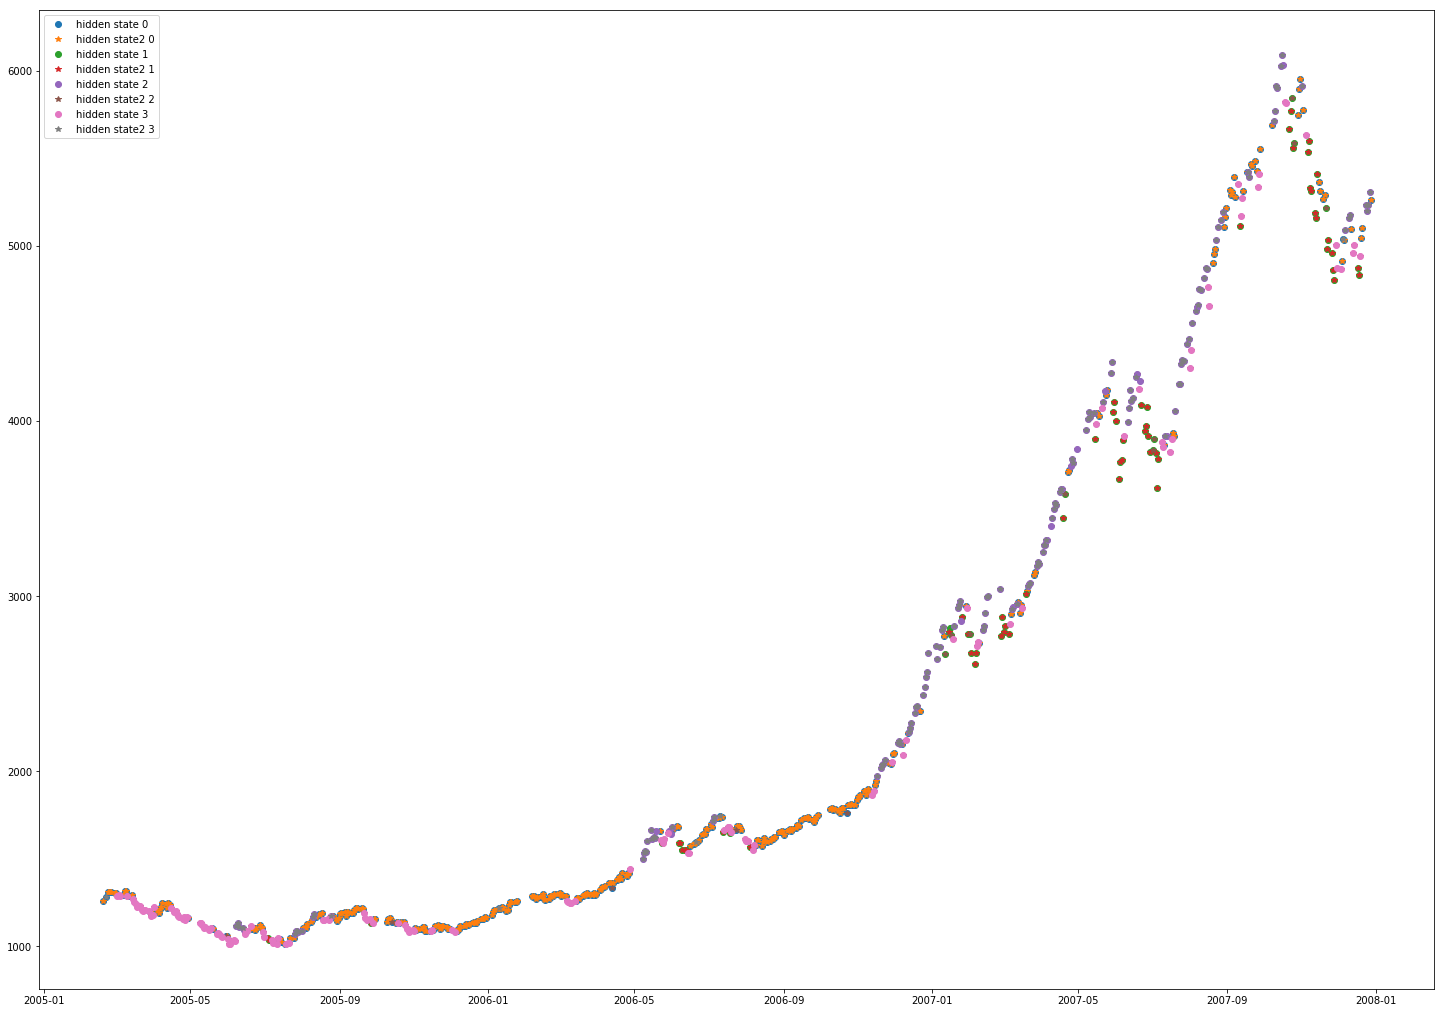

In [213]:
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states == i)
    pos_2 = (hidden_states_2 == i)
    plt.plot_date(Date[pos], close[pos], 'o', label='hidden state %d'%i, lw = 2)
    plt.plot_date(Date[pos_2], close[pos_2], '*', label='hidden state2 %d'%i, lw = 2)
    plt.legend(loc = "best")
plt.show()

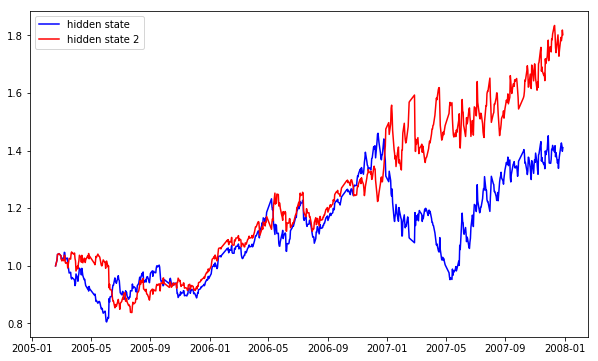

In [214]:
res = pd.DataFrame({'Date': Date, 'logRet_1': log_ret_1, 'state': hidden_states}).set_index('Date')
res_2 = pd.DataFrame({'Date': Date, 'logRet_1': log_ret_1, 'state': hidden_states_2}).set_index('Date')
long = (hidden_states == 0) + (hidden_states == 3)
short = (hidden_states == 1) + (hidden_states == 2)
long = np.append(0, long[:-1])
short = np.append(0, short[:-1])
long_2 = (hidden_states_2 == 0) + (hidden_states_2 == 3)
short_2 = (hidden_states_2 == 1) + (hidden_states_2 == 2)
long_2 = np.append(0, long_2[:-1])
short_2 = np.append(0, short_2[:-1])
plt.figure(figsize=(10, 6)) 
res['ret'] = df.multiply(long) - df.multiply(short) 
res_2['ret'] = df.multiply(long_2) - df.multiply(short_2) 
plt.plot_date(Date, np.exp(res['ret'].cumsum()), "b-",label='hidden state')
plt.plot_date(Date, np.exp(res_2['ret'].cumsum()), "r-",label='hidden state 2')
plt.legend(loc = "best")
plt.show()